In [146]:
import sys, os
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import seaborn as sns
import scipy
%matplotlib inline
results_path = 'Results/'

In [23]:
# Load all tests
all_tests = [i for i in os.listdir(results_path)]
if '.ipynb_checkpoints' in all_tests:
    all_tests.remove('.ipynb_checkpoints')
all_tests = [int(i) for i in all_tests]
all_tests

[1, 10, 11, 12, 13, 2, 3, 4, 5, 7, 8, 9]

In [24]:
def get_data(rock_id, seconds):
    ''' Returns array of temps @ given seconds'''
    
    assert seconds in [0, 10, 30]
    assert rock_id in all_tests
    
    path = results_path + str(rock_id)
    files= os.listdir(path)    
    for file in files:
        if "_"+str(seconds) in file:
            f = open(path + "/" + file, "rb") 
    return np.load(f)

In [25]:
def view(rock_id):
    z, t = get_data(rock_id, 0), get_data(rock_id, 10)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(z, linewidth=0, ax=ax1)
    sns.heatmap(t, linewidth=0, ax=ax2)
    fig.set_size_inches(15, 5)
    fig.show()

def view_img(img):
    sns.heatmap(img, linewidth=0)
    plt.show()

# Analyze

Cold
25.953027173564806 28.29678922872678 38.4608954676851


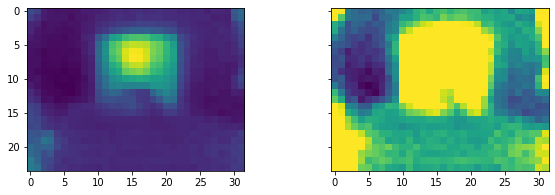

In [321]:
def clean_img(rock_id, seconds):
    
    im = get_data(rock_id, seconds)
    center_data = crop(im, 10)
    center_mean = np.mean(center_data)
    
    if center_mean < np.mean(im) or len(np.where(im > np.mean(im))[0]) > 20:
        print("Cold")
        cold_rock = True
        hot_rock = False
    else:
        print("Hot")
        cold_rock = False
        hot_rock = True
    
    print(im.min(), np.mean(im), im.max())
    
    if cold_rock:
        cleaned = np.clip(im, im.min(), np.mean(im))
    else:
        # hot rock
        cleaned = np.clip(im, np.mean(im), im.max())
    
    # Plot for debugging purposes
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    ax1.imshow(im)
    ax2.imshow(cleaned)
    fig.set_size_inches(10, 3)
    fig.show()
    
clean_img(4,10)

In [66]:
def crop(img, pixel_range = 5):
    x,y = img.shape
    mid_x, mid_y = int(x/2), int(y/2)
    row_indices = range(mid_x-pixel_range, mid_x+pixel_range)
    col_indices = range(mid_y-pixel_range, mid_y+pixel_range)
    cropped = []
    for row in row_indices:
        to_add = []
        cropped.append([])
        for col in col_indices:
            to_add.append(img[row, col])
        cropped[-1] = np.array(to_add)
    return np.array(cropped)

def resize(img, factor):
    return cv.resize(img, dsize=(img.shape[1]*factor,img.shape[0]*factor), interpolation=cv.INTER_CUBIC)

In [303]:
def get_grad(img):
    x,y = np.gradient(img)
    return (x**2+y**2)**0.5

def remove_bg(img):
    x,y = img.shape
    points = [
        [int(i) for i in [x*0.2,y*0.2]],
        [int(i) for i in [x*0.8,y*0.2]],
        [int(i) for i in [x*0.2,y*0.3]],
        [int(i) for i in [x*0.8,y*0.3]],        
    ]
#     view_img(img)
    vals = np.array([img[p[0], p[1]] for p in points])
#     bg_val = np.mean(vals[:2])
    bg_val = vals.min()
#     img[img <= bg_val] = 0.0

#     view_img(np.clip(img, bg_val, img.max()))
    return np.clip(img, bg_val, img.max())

In [304]:
def get_mask(original_im, resize_factor):
    im = get_grad(original_im)
    im = 255*(im - np.min(im))/np.ptp(im) # normalize to rgb values
    im = remove_bg(im) # remove background noise
    im = im.astype(np.uint8)
    im = resize(im, resize_factor) # make bigger
    mask = cv.threshold(im, 0, 255, cv.THRESH_OTSU + cv.THRESH_BINARY)[1]
    mask = scipy.ndimage.morphology.binary_fill_holes(mask)
    return resize(original_im, resize_factor), mask

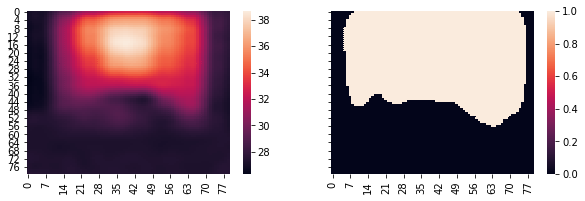

In [306]:
def process_img(rock_id, seconds, resize_factor = 5, plot=True):

    original_im = get_data(rock_id, seconds)
#     print("Max", original_im.max())
    
    # reisizes orignal img and get a mask
    original_im, mask = get_mask(original_im, resize_factor)
    # Crop both
    original_im, mask = (crop(i, int(8*resize_factor)) for i in [original_im, mask])
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
        sns.heatmap(original_im, linewidth=0, ax=ax1)
        sns.heatmap(mask, linewidth=0, ax=ax2)
        fig.set_size_inches(10, 3)
        fig.show()
    
    return original_im[mask]

masked = process_img(4, 10)

---

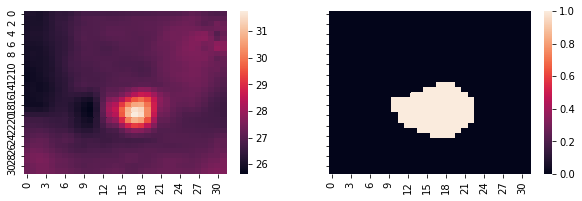

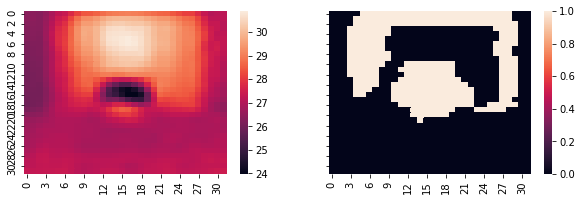

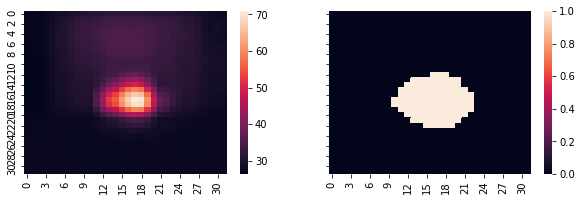

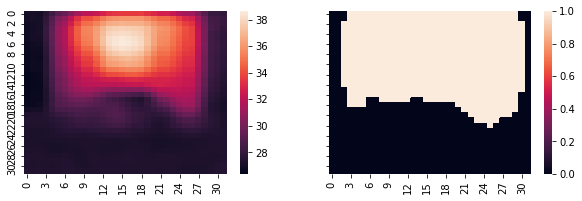

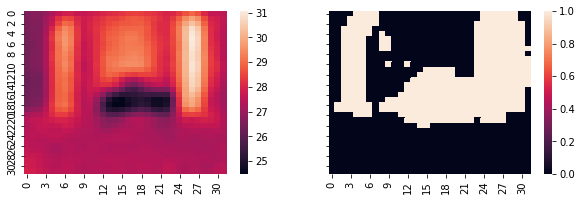

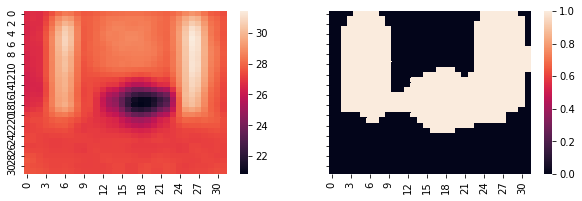

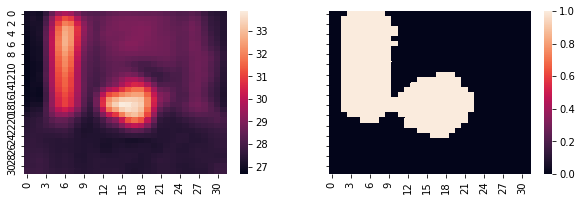

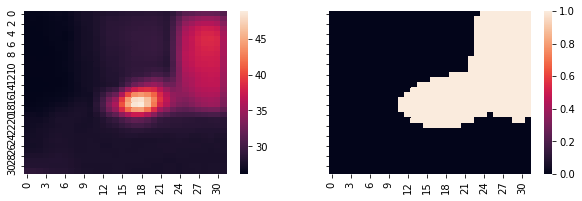

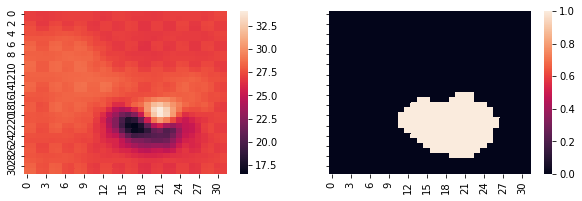

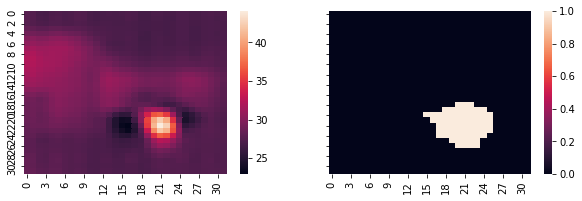

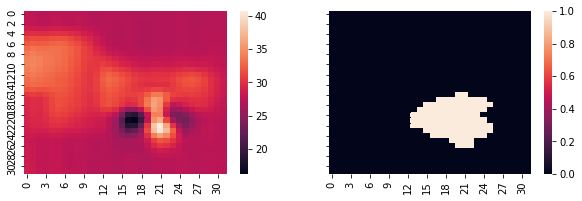

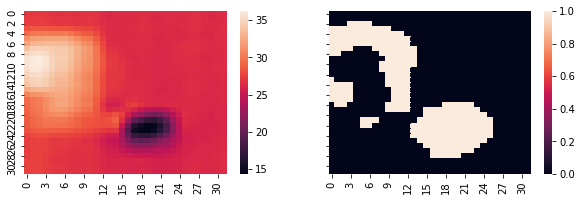

In [308]:
for test in sorted(all_tests):
    for s in [0, 10]:
        if s==10:
            rock = process_img(test, s, plot=True)
#         print(test, s, rock.min(), np.mean(rock), rock.max())